In [1]:
import json
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
print("--- 1. LOADING DATA ---")

# CONFIG: Update these if your folders are different
DATA_FOLDERS = [
    os.path.join('parsed_matches')
]
CHAMP_META_PATH = 'champ_data.csv'

# A. Fetch Item Data (To filter for Legendaries)
try:
    print("Fetching Item Data from Riot API...")
    versions = requests.get("https://ddragon.leagueoflegends.com/api/versions.json").json()
    latest_version = versions[0]
    item_json = requests.get(f"https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/item.json").json()
    
    # Create Lookup & Valid ID Set
    item_lookup = {int(k): v['name'] for k, v in item_json['data'].items()}
    VALID_LEGENDARY_IDS = set()
    
    for k, v in item_json['data'].items():
        item_id = int(k)
        depth = v.get('depth', 1)
        gold_total = v['gold']['total']
        # Rule: Depth >= 3 or Cost > 2000 (Filters out components)
        if depth >= 3 or gold_total > 2000:
            VALID_LEGENDARY_IDS.add(item_id)
            
    print(f"Loaded {len(VALID_LEGENDARY_IDS)} Legendary Items.")
except Exception as e:
    print(f"Error fetching items: {e}")
    # Fallback: empty set (logic will fail if this happens, but prevents crash)
    item_lookup = {}
    VALID_LEGENDARY_IDS = set()

def get_item_name(item_id):
    return item_lookup.get(item_id, f"Item {item_id}")

# B. Load Matches
if os.path.exists(CHAMP_META_PATH):
    champ_meta = pd.read_csv(CHAMP_META_PATH)
    champ_dict = champ_meta.set_index('Champion').to_dict('index')
else:
    print("Warning: champ_data.csv not found. Using raw names.")
    champ_dict = {} # Fallback

def get_legendary_sequence(purchase_list):
    """Returns only LEGENDARY item purchases in order."""
    sorted_events = sorted(purchase_list, key=lambda x: x['timestamp'])
    events = []
    for x in sorted_events:
        if x['type'] == 'ITEM_PURCHASED' and x['itemId'] in VALID_LEGENDARY_IDS:
            events.append((x['itemId'], x['timestamp']))
    return events

training_rows = []
raw_matches = []

print("Reading Match Files...")
for folder in DATA_FOLDERS:
    if not os.path.exists(folder): continue
    for filename in os.listdir(folder):
        if not filename.endswith('.json'): continue
        try:
            with open(os.path.join(folder, filename), 'r') as f:
                raw_matches.append(json.load(f))
        except: continue

print(f"Processing {len(raw_matches)} matches...")

for match_data in raw_matches:
    participants = match_data['participants']
    lane_map = {(p['teamId'], p['lane']): p for p in participants}
    
    for p in participants:
        # Check if champ exists in meta (skip if strictly enforcing meta)
        if champ_dict and p['championName'] not in champ_dict: continue
        
        enemy_team = 200 if p['teamId'] == 100 else 100
        opponent = lane_map.get((enemy_team, p['lane']))
        
        if not opponent: continue
        
        # Get Sequence
        legendary_seq = get_legendary_sequence(p['item_purchases'])
        if len(legendary_seq) < 1: continue 
        
        current_inventory = []
        
        for item_id, timestamp in legendary_seq:
            training_rows.append({
                'my_champ': p['championName'],
                'enemy_champ': opponent['championName'],
                'current_inventory': list(current_inventory),
                'target_item': item_id
            })
            current_inventory.append(item_id)

df = pd.DataFrame(training_rows)
print(f"Dataframe ready with {len(df)} samples.")

--- 1. LOADING DATA ---
Fetching Item Data from Riot API...
Loaded 332 Legendary Items.
Reading Match Files...
Processing 6084 matches...
Dataframe ready with 179677 samples.


In [5]:
print("\n--- 2. PREPARING KNN FEATURES ---")

# A. Encode Target (Y)
item_encoder = LabelEncoder()
y_knn = item_encoder.fit_transform(df['target_item'])

# B. Encode Inventory (Multi-Hot)
mlb = MultiLabelBinarizer(classes=item_encoder.classes_)
X_inv = mlb.fit_transform(df['current_inventory'])

# C. Encode Champions (One-Hot) - CRITICAL for KNN
# We fit on ALL champions to ensure columns match
all_champs = pd.concat([df['my_champ'], df['enemy_champ']]).unique()
oh_encoder = OneHotEncoder(categories=[all_champs, all_champs], handle_unknown='ignore', sparse_output=True)

# Combine My Champ + Enemy Champ into one sparse matrix
X_champs = oh_encoder.fit_transform(df[['my_champ', 'enemy_champ']])

# D. Combine Everything
X_final = hstack([X_champs, X_inv])
print(f"Feature Vector Size: {X_final.shape[1]} dimensions")

# E. Split Data
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_final, y_knn, test_size=0.2, random_state=42)


--- 2. PREPARING KNN FEATURES ---
Feature Vector Size: 449 dimensions


In [11]:
print("\n--- 3. TRAINING KNN MODEL (K=15) ---")
# n_jobs=-1 uses all CPU cores
knn = KNeighborsClassifier(n_neighbors=30, metric='cosine', n_jobs=-1)
knn.fit(X_train_knn, y_train_knn)
print("Training Complete.")

# Generate Predictions
print("Generating predictions for evaluation...")
y_pred_probs_knn = knn.predict_proba(X_test_knn)
y_pred_ids_knn = np.argmax(y_pred_probs_knn, axis=1)

acc_1 = accuracy_score(y_test_knn, y_pred_ids_knn)
print(f"KNN Top-1 Accuracy: {acc_1:.1%}")


--- 3. TRAINING KNN MODEL (K=15) ---
Training Complete.
Generating predictions for evaluation...
KNN Top-1 Accuracy: 42.2%



--- 4. GENERATING REPORT PLOTS ---


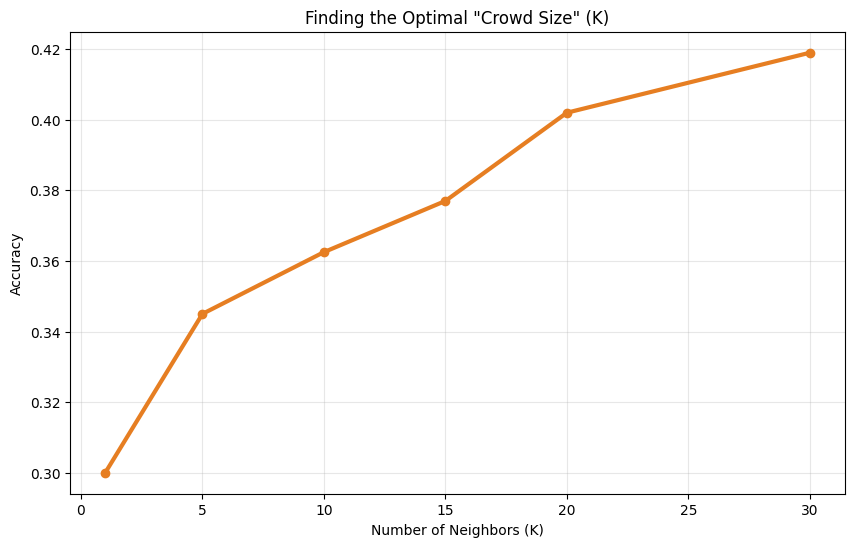

In [12]:
print("\n--- 4. GENERATING REPORT PLOTS ---")

# --- PLOT 1: ELBOW PLOT (Tuning K) ---
k_values = [1, 5, 10, 15, 20, 30]
k_accuracies = []
X_subset = X_test_knn[:2000] # Speed up
y_subset = y_test_knn[:2000]

for k in k_values:
    temp_knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1)
    temp_knn.fit(X_train_knn, y_train_knn)
    k_accuracies.append(temp_knn.score(X_subset, y_subset))

plt.figure(figsize=(10, 6))
plt.plot(k_values, k_accuracies, marker='o', linestyle='-', color='#e67e22', linewidth=3)
plt.title('Finding the Optimal "Crowd Size" (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

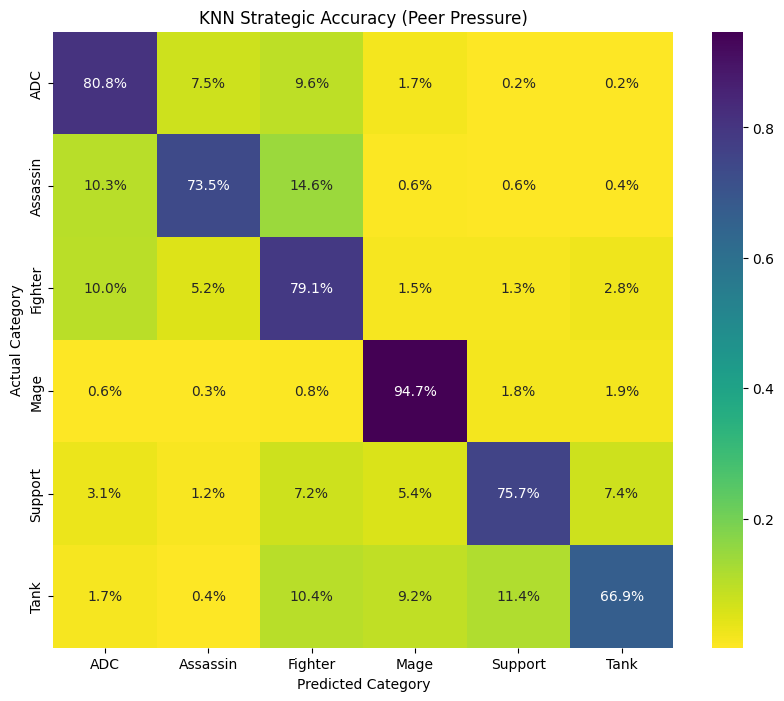

In [13]:
item_archetypes = {
    # FIGHTER
    3078: 'Fighter', 6630: 'Fighter', 6631: 'Fighter', 3071: 'Fighter', 6632: 'Fighter', 
    3053: 'Fighter', 6333: 'Fighter', 3074: 'Fighter', 3748: 'Fighter', 3161: 'Fighter', 
    6692: 'Fighter', 5565: 'Fighter', 3072: 'Fighter', 3153: 'Fighter',
    # TANK
    3068: 'Tank', 3065: 'Tank', 3075: 'Tank', 3001: 'Tank', 3111: 'Tank', 3047: 'Tank', 
    3110: 'Tank', 3025: 'Tank', 3083: 'Tank', 3084: 'Tank', 6665: 'Tank', 6667: 'Tank', 
    5587: 'Tank', 4401: 'Tank', 8001: 'Tank', 2502: 'Tank', 2504: 'Tank',
    # MAGE
    6653: 'Mage', 6655: 'Mage', 3089: 'Mage', 4645: 'Mage', 3157: 'Mage', 3100: 'Mage', 
    3102: 'Mage', 3165: 'Mage', 3116: 'Mage', 3135: 'Mage', 4646: 'Mage', 3118: 'Mage', 
    3003: 'Mage', 3027: 'Mage', 3115: 'Mage', 3152: 'Mage',
    # ADC
    6671: 'ADC', 3031: 'ADC', 3036: 'ADC', 3046: 'ADC', 3094: 'ADC', 3095: 'ADC', 
    6672: 'ADC', 3087: 'ADC', 3033: 'ADC', 6673: 'ADC', 3124: 'ADC', 3091: 'ADC', 3139: 'ADC',
    # ASSASSIN
    3142: 'Assassin', 6691: 'Assassin', 3179: 'Assassin', 3814: 'Assassin', 3134: 'Assassin', 
    6696: 'Assassin', 6695: 'Assassin', 6698: 'Assassin', 3156: 'Assassin', 6676: 'Assassin',
    # SUPPORT
    3190: 'Support', 3174: 'Support', 6617: 'Support', 2065: 'Support', 3504: 'Support', 
    3107: 'Support', 3222: 'Support', 3119: 'Support'
}

def get_archetype(item_id):
    return item_archetypes.get(item_id, 'Other')

# Map predictions
true_cats = [get_archetype(item_encoder.inverse_transform([y])[0]) for y in y_test_knn]
pred_cats = [get_archetype(item_encoder.inverse_transform([y])[0]) for y in y_pred_ids_knn]

# Labels (Excluding 'Other')
labels = ['ADC', 'Assassin', 'Fighter', 'Mage', 'Support', 'Tank']
cm = confusion_matrix(true_cats, pred_cats, labels=labels, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.1%', xticklabels=labels, yticklabels=labels, cmap='viridis_r')
plt.title('KNN Strategic Accuracy (Peer Pressure)')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()

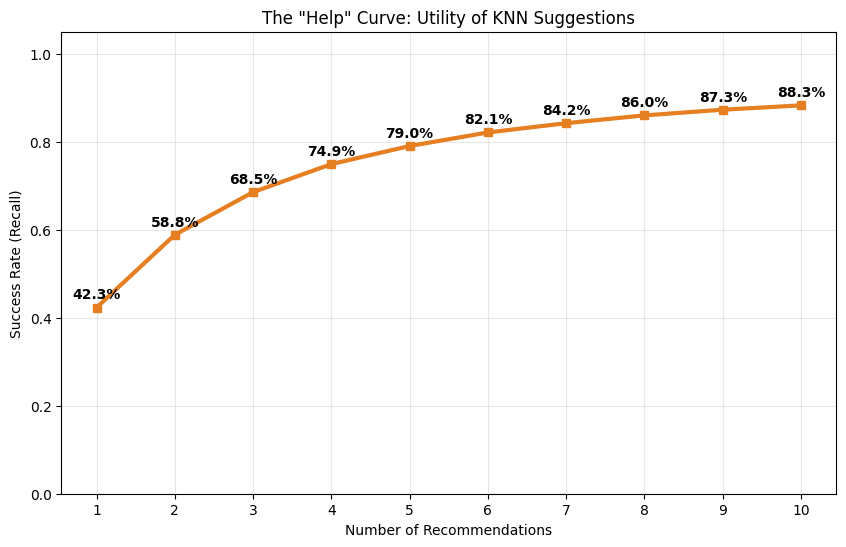

In [14]:
n_range = range(1, 11)
help_accuracies = []
sorted_indices = np.argsort(y_pred_probs_knn, axis=1)

for n in n_range:
    top_n = sorted_indices[:, -n:]
    hits = np.any(top_n == y_test_knn[:, None], axis=1)
    help_accuracies.append(np.mean(hits))

plt.figure(figsize=(10, 6))
plt.plot(n_range, help_accuracies, marker='s', linewidth=3, color='#e67e22')
for n, acc in zip(n_range, help_accuracies):
    plt.text(n, acc + 0.02, f"{acc:.1%}", ha='center', fontweight='bold')
    
plt.title('The "Help" Curve: Utility of KNN Suggestions')
plt.xlabel('Number of Recommendations')
plt.ylabel('Success Rate (Recall)')
plt.ylim(0, 1.05)
plt.xticks(n_range)
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

#Exemple pour un score global
precision, recall, f1,  = precision_recall_fscore_support(
    y_test_knn, y_pred_knn, average='weighted', zero_division=0
)

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1:", f1)

#Classification report propre
print(classification_report(
    y_test_knn, y_pred_knn, digits=4, zero_division=0
))

NameError: name 'y_pred_knn' is not defined